In [1]:
import torch
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer

In [2]:
import os
import cv2

# Load Models

In [3]:
current_folder = globals()['_dh'][0]
print(current_folder)

/home/jacklishufan/UNINEXT/notebooks


In [4]:
os.chdir(os.path.join(current_folder, '..'))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from detectron2.projects.hipie.demo_lib.part_segm_demo import PartSegmDemo
from detectron2.data.detection_utils import read_image,convert_PIL_to_numpy
from fairscale.nn.checkpoint import checkpoint_wrapper 

2023-10-10 19:51:13.860600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 19:51:14.521109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
#torch.cuda.set_device(2)

In [8]:
# config_file = 'projects/HIPIE/configs/image_joint_r50_pan_maskdino_parts.yaml'
# ckpt = 'public/r50_parts.pth'

config_file = 'projects/HIPIE/configs/training/r50_parts.yaml'
ckpt = 'weights/r50_parts.pth'
uninext_demo = PartSegmDemo(config_file=config_file,weight=ckpt,device='cuda')

Some model parameters or buffers are not found in the checkpoint:
detr.mask_dino.predictor.resizer.fc.{bias, weight}
detr.mask_dino.predictor.resizer.layer_norm.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  text_encoder.body.model.embeddings.position_ids
  detr.mask_dino.predictor.label_enc.weight


Length of coco_panoptic Categories : 133
Length of pascal_parts_val Categories : 200
Length of coco_2017_train_panoptic_with_sem_seg Categories : 133


In [9]:
uninext_demo.demo.predictor.model.device 

device(type='cuda')

# Set up an image

In [10]:
imgs = os.listdir('/home/jacklishufan/UNINEXT/datasets/coco/train2017')
i = 900
fpath = f'/home/jacklishufan/UNINEXT/datasets/coco/train2017/{imgs[i]}'

In [38]:
'assets/demo_hipie.jpg'
fpath = 'assets/demo_hipie_2.png'
image = Image.open(fpath)
image = image.resize((600,600))
image_np_d2 = convert_PIL_to_numpy(image, format="BGR")

In [39]:
image_np_d2.shape

(600, 600, 3)

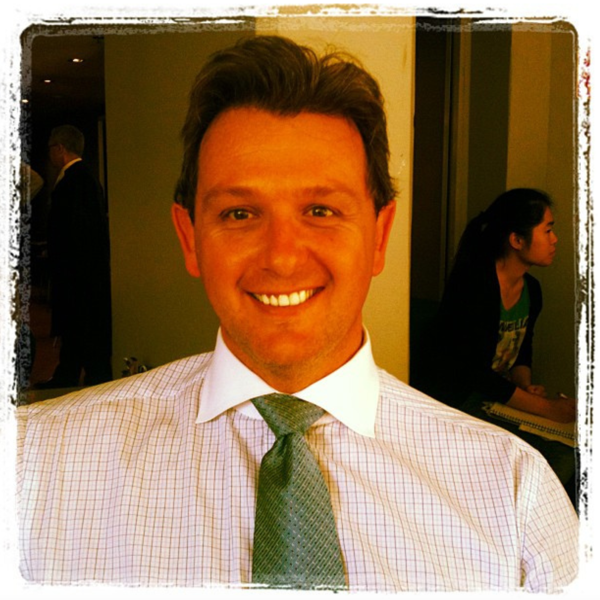

In [40]:
image

In [41]:
from detectron2.projects.hipie.data.coco_dataset_mapper_uni import get_openseg_labels
COCO_OPENSEG_LABELS = get_openseg_labels('coco_panoptic')
coco_labels = dict(
    things_labels=[x['name'] for x in get_openseg_labels('coco_panoptic')[:80]],
    stuff_labels=[x['name'] for x in get_openseg_labels('coco_panoptic')[80:]]
)
custom_labels = dict(
    things_labels=['cats','books','mouse','bottle','clock','cellphone'],
    stuff_labels=['sky','shelf','table']
)

In [42]:
selected_labels = coco_labels

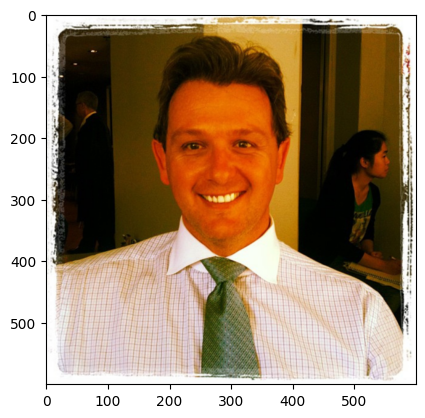

In [43]:
plt.imshow(image)

In [55]:
mask = uninext_demo.foward_panoptic(image_np_d2,do_part=True,instance_thres=0.49,**selected_labels)

/home/jacklishufan/UNINEXT/projects/HIPIE/hipie/demo_lib/part_segm_demo.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parts_seg=torch.tensor(parts_seg),


# Panoptic Seg

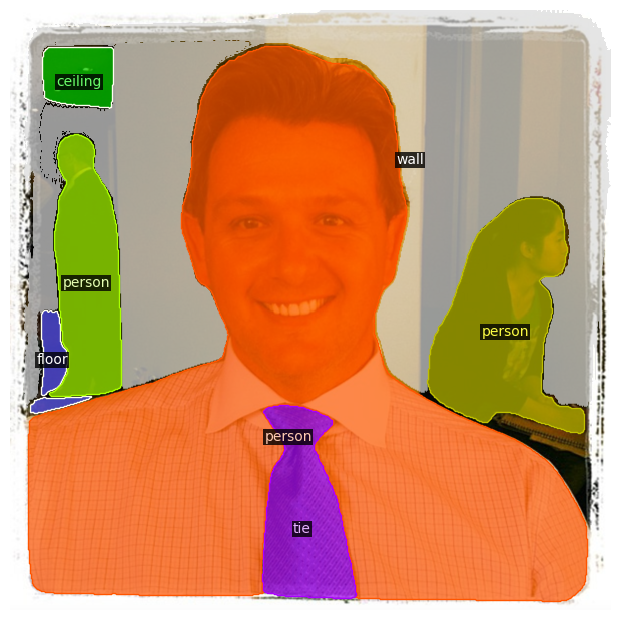

In [57]:
visualizer = Visualizer(image,metadata=mask['meta_data'])
visualizer.draw_panoptic_seg(mask['panoptic_seg'][0].cpu(),mask['panoptic_seg'][1])
visualizer.get_output().fig

#  Part Seg

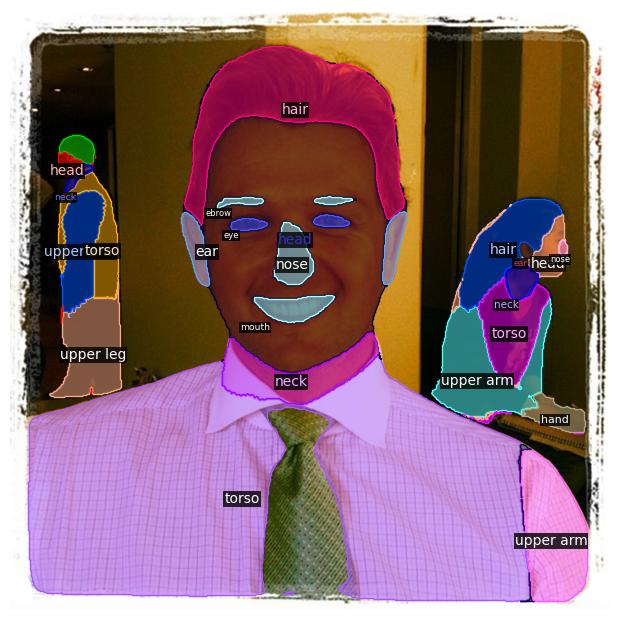

In [58]:
visualizer = Visualizer(image)
visualizer.overlay_instances(masks=torch.stack(mask['output_refined'][0]),labels=mask['output_refined'][1])
visualizer.get_output().fig

# Instance Seg

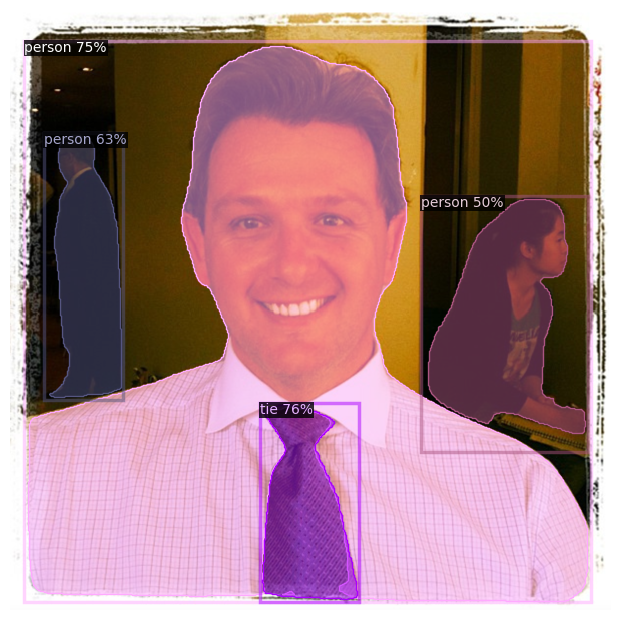

In [60]:
visualizer = Visualizer(image,metadata=mask['meta_data'])
visualizer.draw_instance_predictions(mask['instances'].to('cpu'))
visualizer.get_output().fig

# Referring Seg

In [62]:
ref_str = "the woman at the back"
mask_refer = uninext_demo.foward_reference(image_np_d2,ref_str,'')

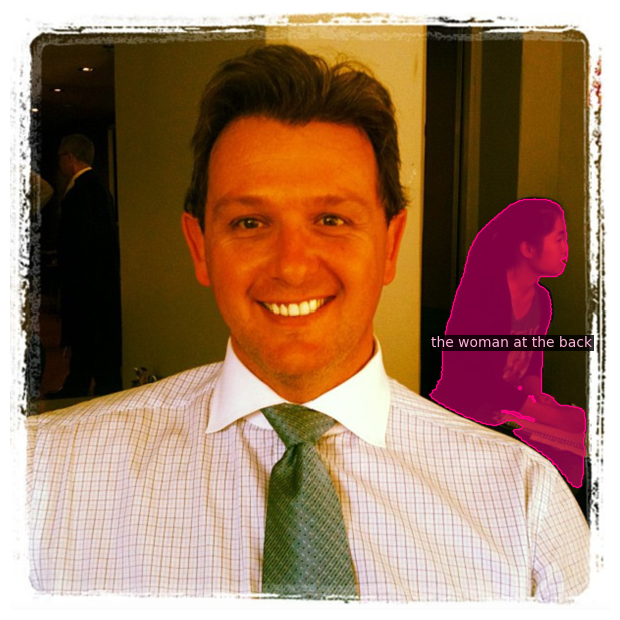

In [63]:
vis= Visualizer(image)
#vis.overlay_instances(masks=mask['instance_mask'])
#vis.overlay_instances(masks=part_mask)
vis.overlay_instances(masks=[mask_refer['final_mask'][0].numpy()],labels=[ref_str])
vis.get_output().fig